In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import nibabel as nib
from surfplot import Plot
from brainspace.mesh import mesh_io, mesh_operations
from neuromaps.datasets import fetch_atlas
import seaborn as sns

from heteromodes.solver import EigenSolver
from heteromodes.utils import load_hmap, unmask
from heteromodes.plotting import plot_brain

In [4]:
def lp_norm(x, mesh, p):
    """Computes the L^p norm of a function u over a 2D triangular mesh."""
    vert_areas = mesh.vertex_areas()

    result = np.sum((x ** p) * vert_areas) ** (1 / p)
    
    return result

def calc_localisation(x, mesh):
    """Computes the localization measure S(u) for a 2D triangular mesh."""
    l2_norm = lp_norm(x, mesh, 2)
    l4_norm = lp_norm(x, mesh, 4)
    return (l2_norm ** 4) / (l4_norm ** 4)

In [5]:
mpl.rcParams['figure.dpi'] = 100
CMEAN = 28.9 * 0.116

In [6]:
# Load and scale hetero map
den = "4k"
fslr = fetch_atlas('fsLR', den)
if den == "32k":
    medmask = nib.load(fslr['medial'][0]).darrays[0].data.astype(bool)
else:
    medmask = nib.load(f"{PROJ_DIR}/data/empirical/fsLR-4k_medmask.label.gii").darrays[0].data.astype(bool)

surf_mid = str(fslr['midthickness'][0])
surf_infl = str(fslr['inflated'][0])

In [7]:
# calculate homogeneous modes
nmodes = 500
mode_ids = [1, 2, 3, 9, 49, 99, 199, 499]
labels = [rf"$\psi_{{{i+1}}}$" for i in mode_ids]

## Calculate homogeneous modes

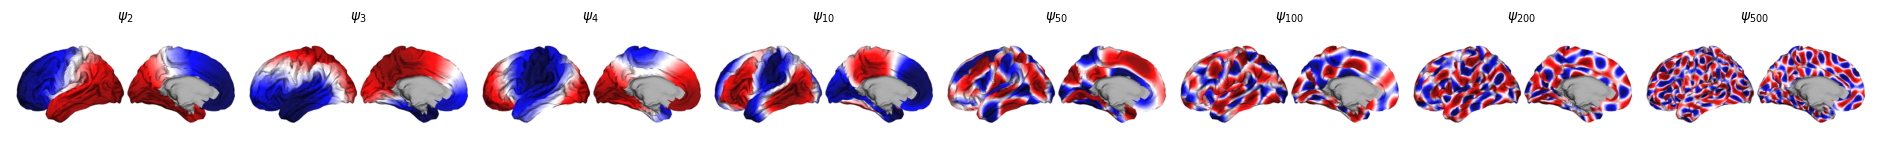

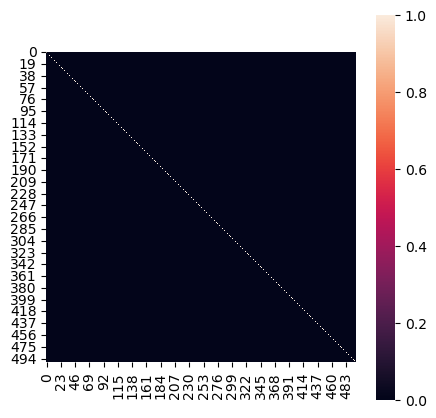

In [8]:
solver_hom = EigenSolver(surf=surf_mid, medmask=medmask, hetero=None, alpha=0)
evals_hom, emodes_hom = solver_hom.solve(n_modes=nmodes, fix_mode1=True, standardise=True)

data = unmask(emodes_hom, medmask)[:, mode_ids]
fig1 = plot_brain(surf_mid, data, labels, cmap="seismic", layout="row", clim_q=[5, 95])

fig2 = plt.figure(figsize=(5, 5))
sns.heatmap(emodes_hom.T @ solver_hom.mass @ emodes_hom, square=True)

plt.show()

## Calculate heterogeneous modes

TriaMesh with anisotropic Laplace-Beltrami


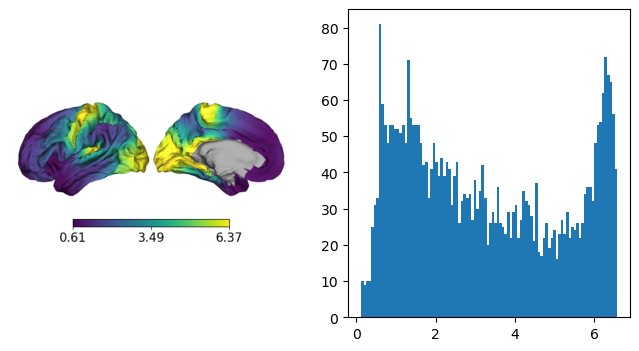

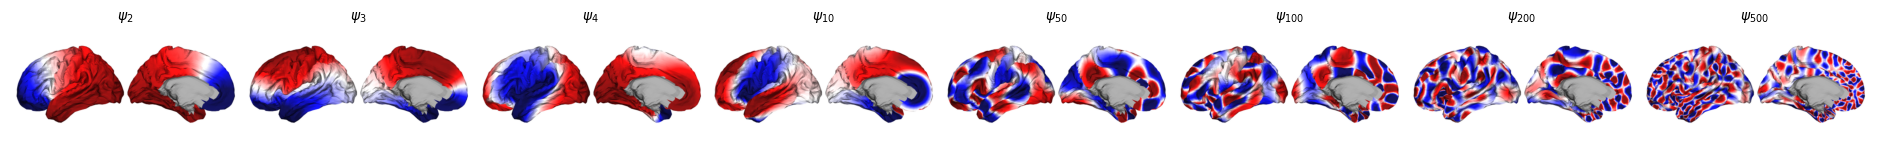

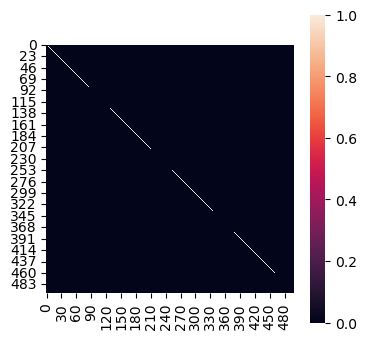

In [23]:
# Calculate hetero modes
hmap_label = "myelinmap"
alpha = 2
sigma = 10
scaling = "sigmoid"
q_norm = None

hmap = load_hmap(hmap_label, trg_den=den)
solver_het = EigenSolver(surf=surf_mid, medmask=medmask, hetero=hmap, alpha=alpha, sigma=sigma, verbose=True, 
                         scaling=scaling, q_norm=q_norm)
evals_het, emodes_het = solver_het.solve(n_modes=nmodes, fix_mode1=True, standardise=True)

# Plot rho map
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs = axs.ravel()

# Plot rho distribution
plot_brain(surf_mid, unmask(CMEAN*solver_het.rho, medmask), cbar=True, ax=axs[0], clim_q=(5, 95))
axs[1].hist(CMEAN*solver_het.rho, bins=100)

labels = [rf"$\psi_{{{i+1}}}$" for i in mode_ids]
fig2 = plot_brain(surf_mid, unmask(emodes_het, medmask)[:, mode_ids], labels, layout="row", cmap="seismic", clim_q=[5, 95])

fig3 = plt.figure(figsize=(4, 4))
sns.heatmap(emodes_het.T @ solver_het.mass @ emodes_het, square=True)
plt.show()

## Compare hom. and het. modes

Text(77.92222222222227, 0.5, 'Homogeneous modes')

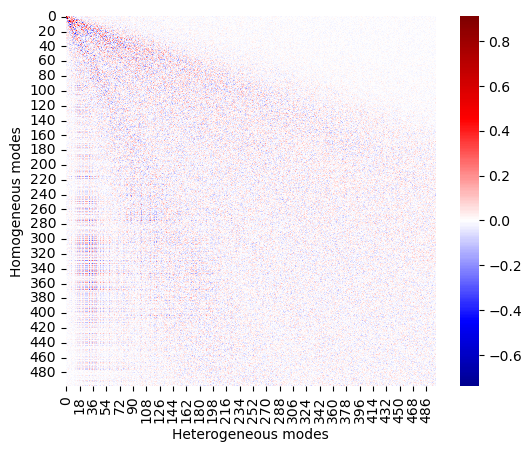

In [24]:
# Plot correlation matrix
corr = np.corrcoef(emodes_hom[:, 1:nmodes], emodes_het[:, 1:nmodes], rowvar=False)[:nmodes-1, nmodes-1:]

sns.heatmap(corr, center=0, square=True, cmap="seismic")
plt.gca().set_xlabel("Heterogeneous modes")
plt.gca().set_ylabel("Homogeneous modes")

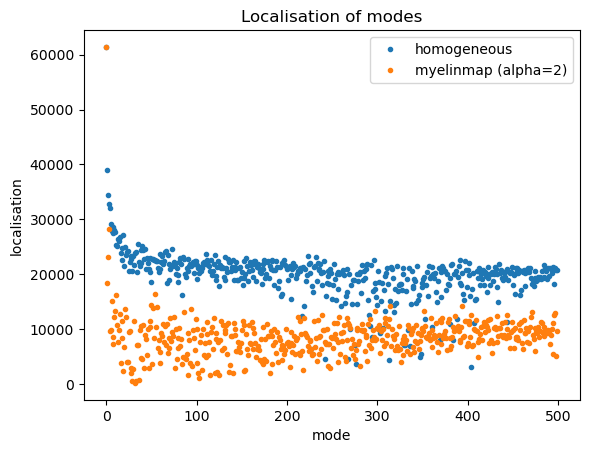

In [25]:
# calculate localisation
loc_hom, loc_het = np.empty((nmodes)), np.empty((nmodes))
for i in range(nmodes):
    loc_hom[i] = calc_localisation(emodes_hom[:, i], solver_hom.mesh)
    loc_het[i] = calc_localisation(emodes_het[:, i], solver_het.mesh)

plt.plot(loc_hom, '.', label="homogeneous")
plt.plot(loc_het, '.', label=f"{hmap_label} (alpha={alpha})")
plt.xlabel("mode")
plt.ylabel("localisation")
plt.title("Localisation of modes")
plt.legend()
plt.show()

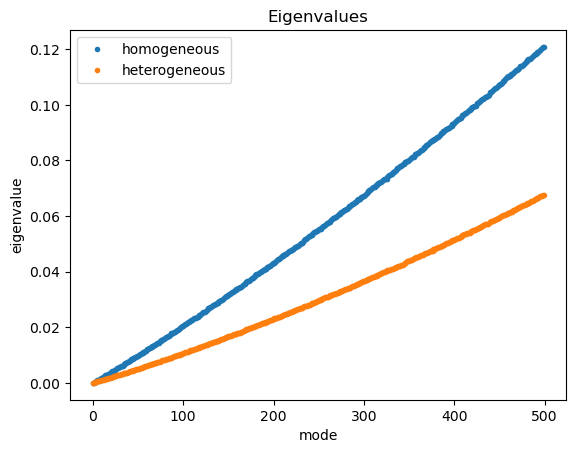

In [26]:
# Plot evals

plt.plot(evals_hom, ".", label="homogeneous")
plt.plot(evals_het, ".", label="heterogeneous")
plt.title("Eigenvalues")
plt.xlabel("mode")
plt.ylabel("eigenvalue")
plt.legend()
plt.show()